In [44]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [45]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint

from SVD import Metrics, SVDPredictor, LogisticSVD, FastLogisticSVD
from RecData import RecData

In [46]:
# recs = pd.read_csv('data/recommendations.csv')
# recs = pd.read_csv('data/pruned.csv')
recs = pd.read_csv('data/2plus.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.head()

Shape: (10267907, 3)


,app_id,is_recommended,user_id
7613972,459080,True,615114
1976676,1222140,True,6729601
4078085,860510,True,1646741
4077313,641320,False,2433891
4077199,728880,True,1803907


In [47]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

del recs

start_time = time.time()
print("Creating splits...")
train_data, test = rec_data.train_test_split(test_size=0.2)
print("First split done.")
train_data, val = train_data.train_test_split(test_size=0.2)
print("Done creating splits in", time.time() - start_time, "seconds")

Creating utility matrix...
Done utility matrix.
Creating splits...
First split done.
Done creating splits in 45.21025037765503 seconds


In [48]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# del recs

# print("Creating splits...")
# train_data, val, test = rec_data.leave_k_out_split(k=1)
# print("Done creating splits.")

In [49]:
del rec_data
del item_data
del titles

Epoch 0/Training error: 0.6931206857802799/Validation error: 0.6931472700409621/Time: 26.17 seconds
Epoch 1/Training error: 0.6930475548278096/Validation error: 0.6931441932521449/Time: 26.42 seconds
Epoch 2/Training error: 0.6926856926212883/Validation error: 0.6931037194840526/Time: 26.41 seconds
Epoch 3/Training error: 0.6902260230446142/Validation error: 0.6926044668361779/Time: 26.45 seconds
Epoch 4/Training error: 0.6722790633528771/Validation error: 0.6872496497635393/Time: 26.31 seconds
Epoch 5/Training error: 0.601825263943075/Validation error: 0.6577494173080554/Time: 26.42 seconds
Epoch 6/Training error: 0.4919112615498562/Validation error: 0.6017312356582095/Time: 26.48 seconds
Epoch 7/Training error: 0.3938776178509988/Validation error: 0.5515429036935225/Time: 27.33 seconds
Epoch 8/Training error: 0.3236872709483169/Validation error: 0.5199657574657676/Time: 26.58 seconds
Epoch 9/Training error: 0.27339400009664/Validation error: 0.5024541366248223/Time: 26.52 seconds
Epo

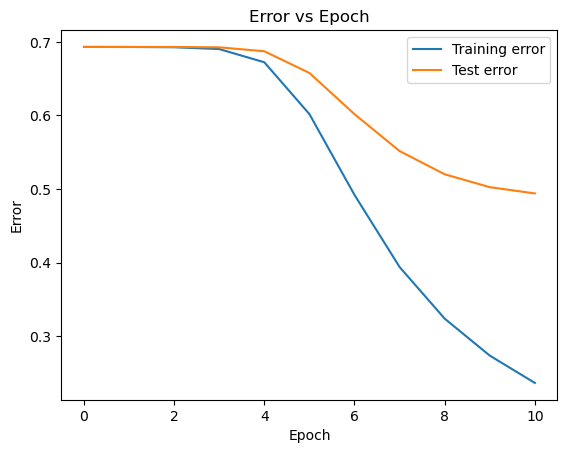

Test rmse 0.3973372791053389


In [51]:
EPOCHS = 11 #240

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = FastLogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=50, 
    learning_rate=0.01, C=0)
svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

In [ ]:
svd_predictor.continue_fit(20, early_stop=False)

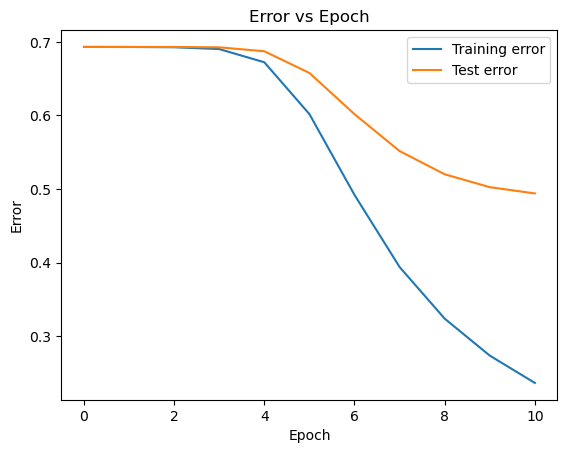

Test rmse 0.3973372791053389


In [52]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

In [299]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([train_data, svd_predictor], file)
print("Done saving model.")

Saving model...
Done saving model.


In [77]:
j = 23
# Test top-n list for user j
top_n = svd_predictor.top_n(j, 20)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = train_data.top_n(j, 5000)
pprint([train_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(0.9822075877476546, 'Wallpaper Engine'),
 (0.9762333262250193, 'Hearts of Iron IV'),
 (0.974505421024758, 'Rust'),
 (0.9686574724980908, "Garry's Mod"),
 (0.967167341139786, 'Halo: The Master Chief Collection'),
 (0.9667279671617098, 'American Truck Simulator'),
 (0.9662704014093119, 'Sea of Thieves'),
 (0.9648488070966827, 'Borderlands 2'),
 (0.9647090501570866, 'Arma 3'),
 (0.9618066631143212, 'Red Dead Redemption 2'),
 (0.9589776580896062, 'The Witcher® 3: Wild Hunt'),
 (0.9586085735904172, 'Kerbal Space Program'),
 (0.9575136508575244, 'Left 4 Dead 2'),
 (0.9570631061219081, 'Terraria'),
 (0.9556164417069387, 'STAR WARS Jedi: Fallen Order Deluxe Edition'),
 (0.9553190217726297, 'ELDEN RING'),
 (0.9535906191960719, 'Inscryption'),
 (0.9527489814147007, 'The Binding of Isaac: Rebirth'),
 (0.9521903196550989, 'Euro Truck Simulator 2'),
 (0.9521589086597719, 'Factorio')]
True top n:
['BeamNG.drive', 'Grand Theft Auto IV: The Complete Edition']


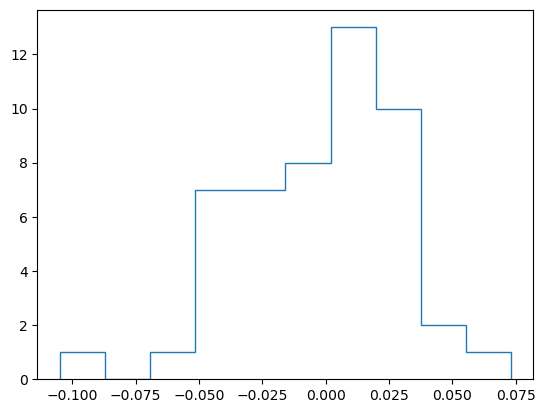

In [78]:
values, bins = np.histogram(svd_predictor._user_features[0, :])
plt.stairs(values, bins)
plt.show()

In [86]:
train_data.search_title('a hat')

[('A Hat in Time', 819)]

In [87]:
prefs = [(196, 0), (740, 1), (174, 1), (819, 1)]
# prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, train_data.index_to_title(index), pref) for index, pref in prefs])
prefs = train_data.create_prefs(prefs)    

[(196, 'Mortal Kombat X', 0),
 (740, 'The Sims™ 3', 1),
 (174, 'The Sims™ 4', 1),
 (819, 'A Hat in Time', 1)]


In [ ]:
start_time = time.time()
svd_predictor.partial_fit(prefs, epochs=EPOCHS)
print("Completed partial fit in", time.time() - start_time, "seconds")

In [ ]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])